In [1]:
# Download all the files we needed from github
import sys
import zipfile
import os

if 'google.colab' in sys.modules:
    !wget --no-check-certificate \
    "https://github.com/XuetingPu/15688-tutorial-data/archive/refs/heads/main.zip" \
    -O "/content/data.zip"

    zip_ref = zipfile.ZipFile('/content/data.zip', 'r') 
    zip_ref.extractall("/content") 
    zip_ref.close()

--2022-07-20 00:21:18--  https://github.com/XuetingPu/15688-tutorial-data/archive/refs/heads/main.zip
Resolving github.com (github.com)... 52.69.186.44
Connecting to github.com (github.com)|52.69.186.44|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://codeload.github.com/XuetingPu/15688-tutorial-data/zip/refs/heads/main [following]
--2022-07-20 00:21:18--  https://codeload.github.com/XuetingPu/15688-tutorial-data/zip/refs/heads/main
Resolving codeload.github.com (codeload.github.com)... 52.193.111.178
Connecting to codeload.github.com (codeload.github.com)|52.193.111.178|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified [application/zip]
Saving to: ‘/content/data.zip’

/content/data.zip       [       <=>          ]  19.77M  10.0MB/s    in 2.0s    

2022-07-20 00:21:21 (10.0 MB/s) - ‘/content/data.zip’ saved [20732461]



## Introduction

NetCDF(Network Common Data Form) is a data format that is often used in climatology, meteorology, oceanography and other fields, such as weather forecasting, climate change, etc. NetCDF has a lot of advantages: self-describing, portable, scalable, appendable, sharable, and archivable. This tutorial will introduce you how to load NetCDF data into Python, how to understand this kind of data, and how to visualize and apply it. 

## Tutorial Content

This tutorial will introduce you how to read data by using [netCDF4](https://unidata.github.io/netcdf4-python/) and [xarray](https://docs.xarray.dev/en/stable/), How do you look at these numbers from a meteorological perspective, how to visualize data by using [xarray](https://docs.xarray.dev/en/stable/), how to draw a map and plot data on a map using [Basemap](https://matplotlib.org/basemap/). At last, we will create a gif to show the precipitation data changed with time.

The following topics will be covered in this tutorial:
- [Installing_the_libraries](#Installing_the_libraries)
- [Loading_data](#Loading_data)
- [Visualization](#Visualization)
- [Animation](#Animation)

## Installing_the_libraries

In this tutorial, we will need install following libraries. [netCDF4](https://unidata.github.io/netcdf4-python/) and [xarray](https://docs.xarray.dev/en/stable/) are very simple to install by using `pip`. If your computer can not install it, you can follow the instruction from [netCDF4 installation](https://unidata.github.io/netcdf4-python/#quick-install) and [xarray installation](https://docs.xarray.dev/en/stable/getting-started-guide/installing.html):

    $ pip install netCDF4
    
    $ pip install xarray

When installing [Basemap](https://matplotlib.org/basemap/), it will be a little bit tricky. On my machine, I can only install it using anaconda and downgrade matplotlib to 3.2 version. But on Colab, you can use following code to install it:

    $ conda install -c anaconda basemap
    
    $ pip install -U matplotlib==3.2

    $ !pip install "basemap == 1.3.0b1" "basemap-data == 1.3.0b1"

In [ ]:
# Install Basemap
!pip install "basemap == 1.3.0b1" "basemap-data == 1.3.0b1"

In [ ]:
# Now we import these libraries
import netCDF4 as nc
import xarray as xr
from mpl_toolkits.basemap import Basemap
import matplotlib.pyplot as plt
import numpy as np
import matplotlib as mpl
import requests
mpl.rcParams['figure.dpi'] = 200
mpl.rcParams['figure.figsize']=(10,5)

## Loading_data

There are two methods to load data, the first one is using `netCDF4`, the second can use `xarray`. In this tutorial, we will use a NetCDF dataset from NOAA (https://psl.noaa.gov/data/gridded/data.cmap.html). This dataset records monthly averaged precipitation rate values (mm/day) from 1979/01 to 2022/02, which used 2.5 degree latitude x 2.5 degree longitude global grid (144x72). According to this dataset, scientist can analyze global precipitation or region precipitation. Then can give some advice to evaluate the environment.

### netCDF4

`netCDF4` is a specific library to write and read NetCDF format file. First, we can use `nc.Dataset` to load data into Python, and choose mode `r+`, `w`, etc.

In [ ]:
file = "/content/15688-tutorial-data-main/precip.mon.mean.nc"
data = nc.Dataset(file)
data

<class 'netCDF4._netCDF4.Dataset'>
root group (NETCDF4_CLASSIC data model, file format HDF5):
    Conventions: COARDS
    title: CPC Merged Analysis of Precipitation (excludes NCEP Reanalysis)
    platform: Analyses
    source: ftp ftp.cpc.ncep.noaa.gov precip/cmap/monthly
    dataset_title: CPC Merged Analysis of Precipitation
    documentation: https://www.esrl.noaa.gov/psd/data/gridded/data.cmap.html
    date_modified: 26 Feb 2019
    References: https://www.psl.noaa.gov/data/gridded/data.cmap.html
    version: V2203
    history: update 03/2022 V2203
    data_modified: 2022-03-07
    dimensions(sizes): lon(144), lat(72), time(518)
    variables(dimensions): float32 lat(lat), float32 lon(lon), float64 time(time), float32 precip(time, lat, lon)
    groups: 

`print` what we have read out, these are simple description of this dataset. For example, the `title` of this dataset is `CPC Merged Analysis of Precipitation`, the `source` of this dataset is `ftp ftp.cpc.ncep.noaa.gov precip/cmap/monthly`, the `dimensions` of the dataset are three: `longitude`, `latitude`, `time`. These information give us a first look of the dataset. Then we use `data.varibles.keys()` to check how many variables there are.

In [ ]:
for i in data.variables.keys():
    print(i)

lat
lon
time
precip


There are four variables. You can think about `lat` and `lon` as grids. `precip` as the values of each point in the grids. We can check one of these variables by using `data.variables['variable_name']`.

In [ ]:
print(data.variables['precip'])

<class 'netCDF4._netCDF4.Variable'>
float32 precip(time, lat, lon)
    long_name: Average Monthly Rate of Precipitation
    valid_range: [ 0. 70.]
    units: mm/day
    add_offset: 0.0
    scale_factor: 1.0
    missing_value: -9.96921e+36
    precision: 2
    least_significant_digit: 2
    var_desc: Precipitation
    dataset: CPC Merged Analysis of Precipitation Standard
    level_desc: Surface
    statistic: Mean
    parent_stat: Mean
    actual_range: [  0.   144.49]
unlimited dimensions: time
current shape = (518, 72, 144)
filling on, default _FillValue of 9.969209968386869e+36 used


Now, we can get information of specific variables. For example, `precip` represents `Average Monthly Rate of Precipitation`, its units is `mm/day`, and `range` of the variable is `[0,144.49]`. [Note]: its `missing value` are replaced by `-9.96921e+36`, we will replace these missing values later. Also, its shape is `(518(time),72(lat),144(lon))`. We can get variable values by using `data.variables['variable_name'][:].data`.

In [ ]:
precip = data.variables['precip'][:].data
print('shape of precip: ',precip.shape)
print('type of precip: ',type(precip))

shape of precip:  (518, 72, 144)
type of precip:  <class 'numpy.ndarray'>


Now, the type of `precip` is a numpy.ndarray. We can slice data just like a numpy.ndarray. For example, I choose `time = 500`, which represents values at all latitude and longtitude grids on September, 2020. (From 1979/01 to 2022/02, there are 518 months.)

In [ ]:
precip_500 = precip[500,:,:]
precip_500

array([[-9.96921e+36, -9.96921e+36, -9.96921e+36, ..., -9.96921e+36,
        -9.96921e+36, -9.96921e+36],
       [ 1.20000e-01,  1.20000e-01,  1.20000e-01, ...,  1.50000e-01,
         1.50000e-01,  1.20000e-01],
       [ 1.00000e-01, -9.96921e+36, -9.96921e+36, ...,  1.20000e-01,
         1.00000e-01,  1.20000e-01],
       ...,
       [ 5.10000e-01,  5.00000e-01,  5.00000e-01, ...,  5.00000e-01,
         4.90000e-01,  4.80000e-01],
       [ 5.30000e-01,  5.30000e-01,  5.20000e-01, ...,  5.50000e-01,
         5.30000e-01,  5.20000e-01],
       [ 7.80000e-01,  7.10000e-01,  6.70000e-01, ...,  5.80000e-01,
         5.70000e-01,  5.60000e-01]], dtype=float32)

Now, these data represents an array which `time = 500`, we can see there are some `-9.96921e+36`, these are missing values. We will deal with these missing values later.

## xarray

`xarray` is another library can deal with NetCDF format well, it has a lot of methods which are similar to `pandas` and `numpy`. `xarry` has two core data structures: `DataArray` and `Dataset`. DataArray is very similar to `numpy.ndarray`. Meanwhile, it also can use `groupby` methods which used in `pandas`. Also, it can visualize data in a simple way. First, we use `xr.open_dataset(file)` to load data.

In [ ]:
data = xr.open_dataset(file)
data

<xarray.Dataset>
Dimensions:  (lat: 72, lon: 144, time: 518)
Coordinates:
  * lat      (lat) float32 88.75 86.25 83.75 81.25 ... -83.75 -86.25 -88.75
  * lon      (lon) float32 1.25 3.75 6.25 8.75 11.25 ... 351.2 353.8 356.2 358.8
  * time     (time) datetime64[ns] 1979-01-01 1979-02-01 ... 2022-02-01
Data variables:
    precip   (time, lat, lon) float32 ...
Attributes:
    Conventions:    COARDS
    title:          CPC Merged Analysis of Precipitation (excludes NCEP Reana...
    platform:       Analyses
    source:         ftp ftp.cpc.ncep.noaa.gov precip/cmap/monthly
    dataset_title:  CPC Merged Analysis of Precipitation
    documentation:  https://www.esrl.noaa.gov/psd/data/gridded/data.cmap.html
    date_modified:  26 Feb 2019
    References:     https://www.psl.noaa.gov/data/gridded/data.cmap.html
    version:        V2203
    history:        update 03/2022 V2203
    data_modified:  2022-03-07

The output is very well-organized and well-integrated. You have the option of viewing `Dimensions`, `Coordinates`, `Data variables`, `Attributes`. Each variable and coordinate has two parts: attributes and values . As a result, loading data in this way can give you a intuitive sense about dataset. If you only want to see one variable, you can use `data['variable_name']`.

In [ ]:
precip = data["precip"]
precip

<xarray.DataArray 'precip' (time: 518, lat: 72, lon: 144)>
[5370624 values with dtype=float32]
Coordinates:
  * lat      (lat) float32 88.75 86.25 83.75 81.25 ... -83.75 -86.25 -88.75
  * lon      (lon) float32 1.25 3.75 6.25 8.75 11.25 ... 351.2 353.8 356.2 358.8
  * time     (time) datetime64[ns] 1979-01-01 1979-02-01 ... 2022-02-01
Attributes:
    long_name:     Average Monthly Rate of Precipitation
    valid_range:   [ 0. 70.]
    units:         mm/day
    precision:     2
    var_desc:      Precipitation
    dataset:       CPC Merged Analysis of Precipitation Standard
    level_desc:    Surface
    statistic:     Mean
    parent_stat:   Mean
    actual_range:  [  0.   144.49]

## Visualization

As I mentioned above, `xarray` can visualize data. The simplest way is to call `DataArray.plot()`, it will give you a histogram of the variable.

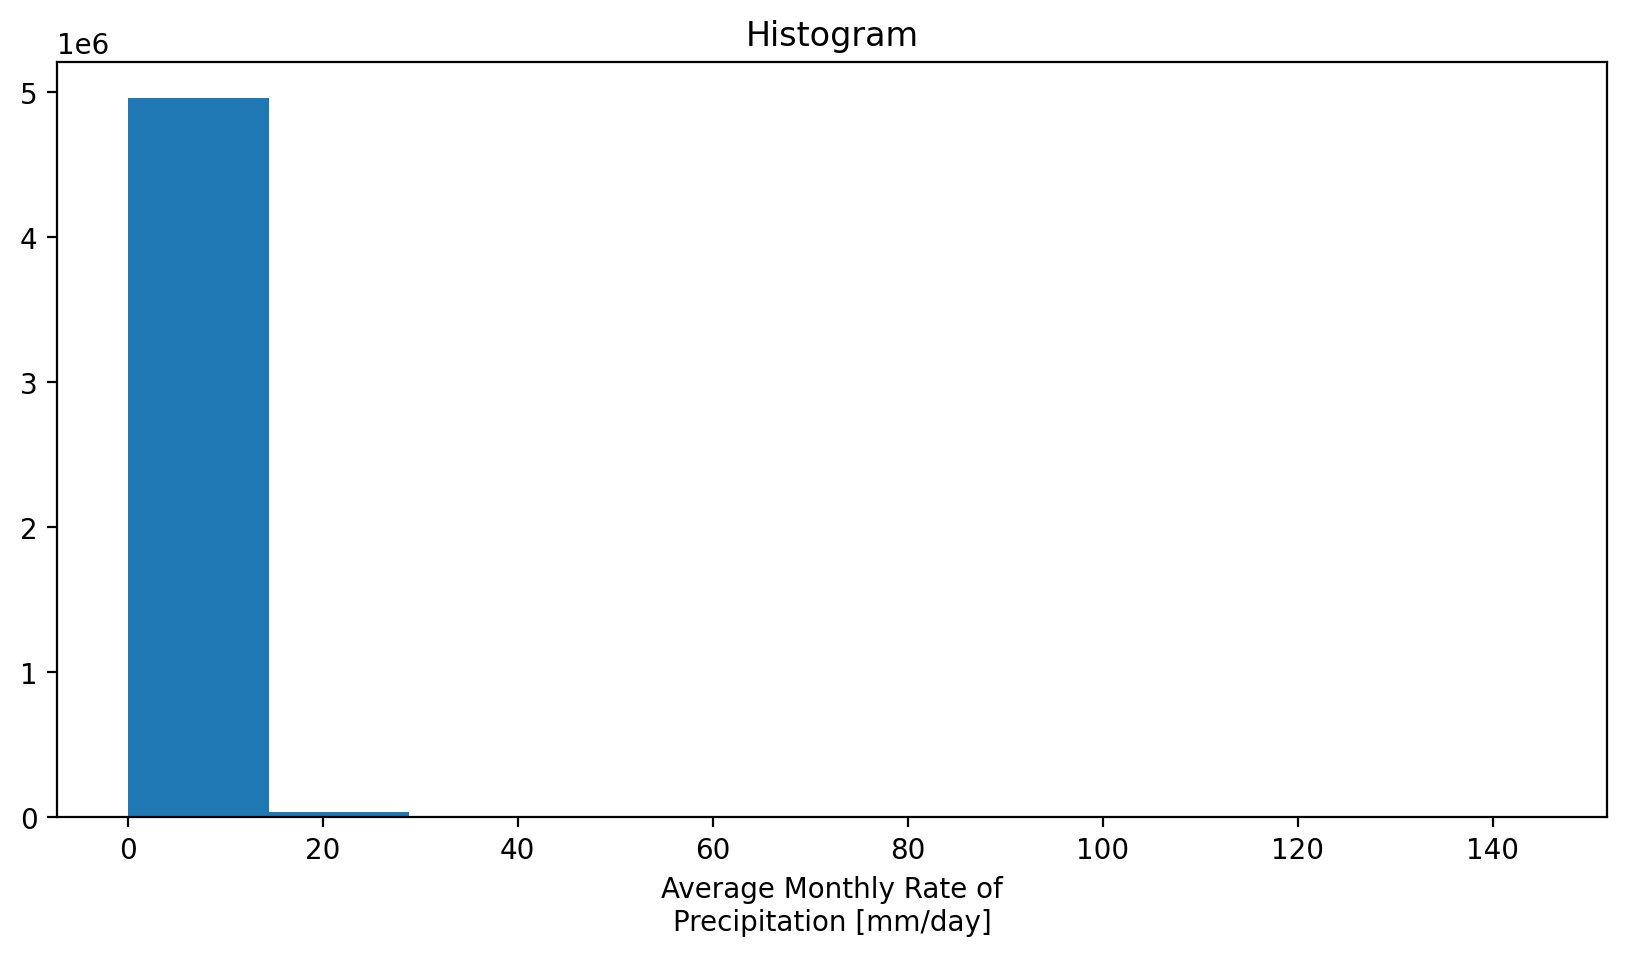

In [ ]:
precip.plot();

From this figure, we can figure out almost all average monthly rate of precipitation value range from 0 to 20 mm/day. Also, we can use `DataArray.isel().plot()` to plot. If we clarify two coordinates, it will output a 1-D plot. For example, `DataArray.isel().plot.line()` calls `matplotlib.pyplot.plot`, so you can use argument that used in matplotlib. xarray will add variable name, coordinate name and axes automatically.

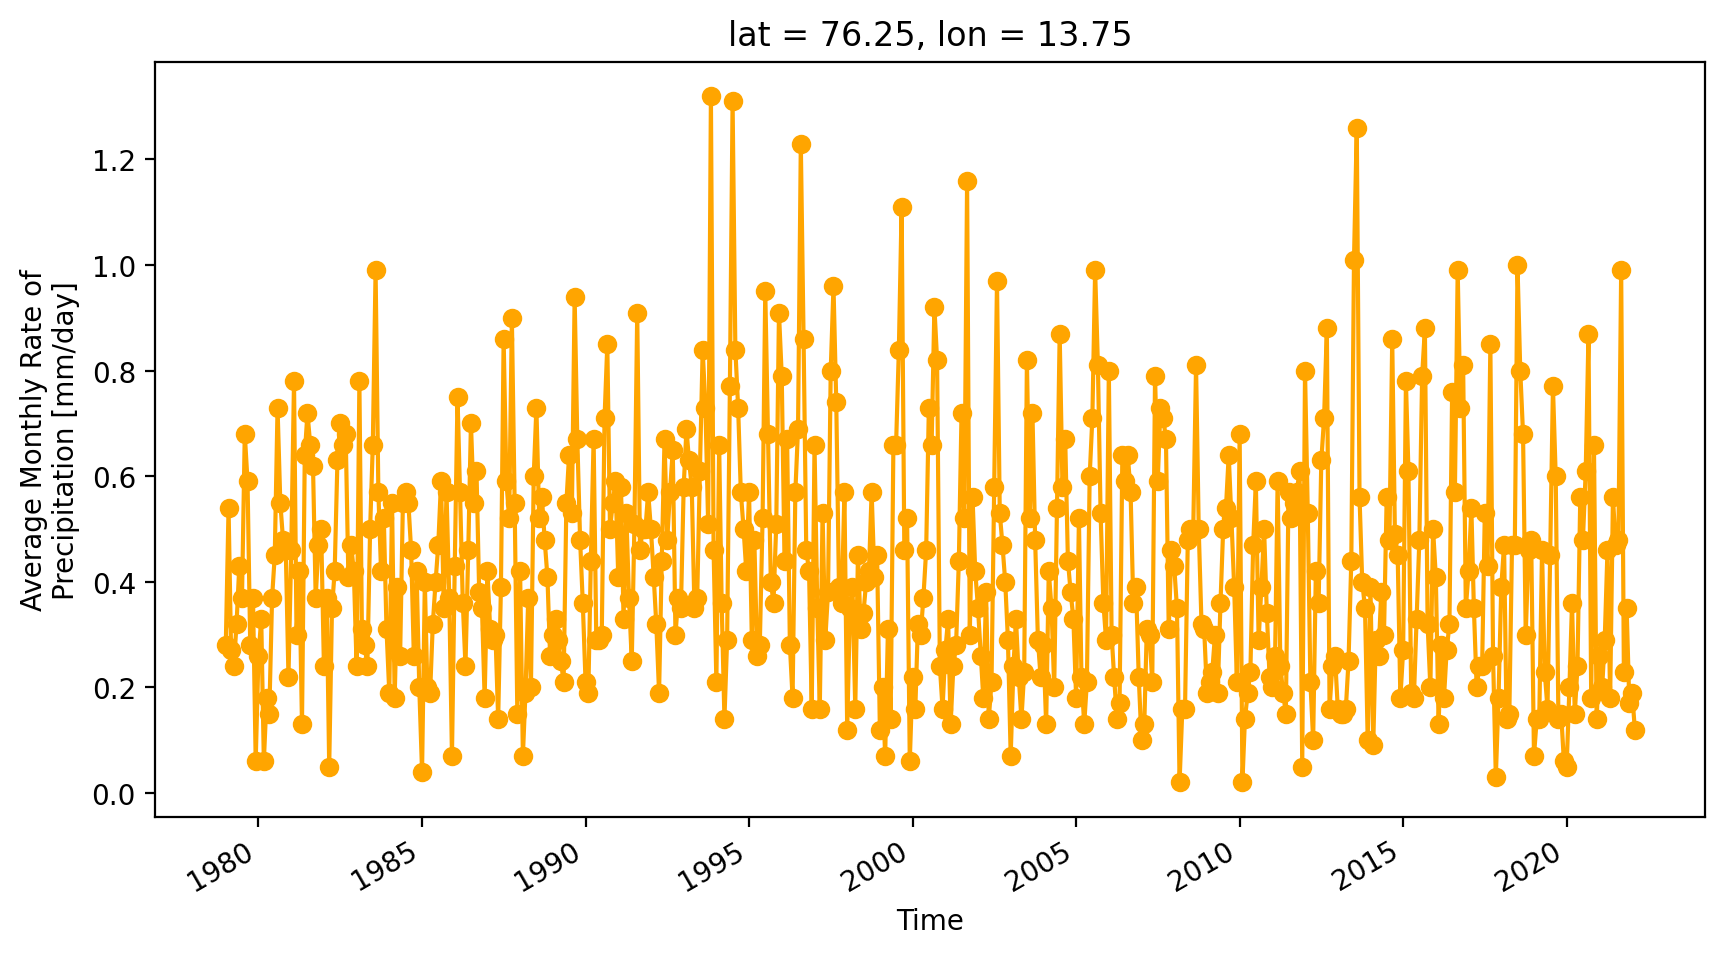

In [ ]:
precip.isel(lat = 5,lon = 5).plot.line(color="orange", marker="o")

If we only clarify one coordinate, it will give us a 2-D plot. By default, `DataArray.isel().plot()`calls `pcolormesh()` when the data is 2-D. You can define color you like. xarray will add colorbar for you.

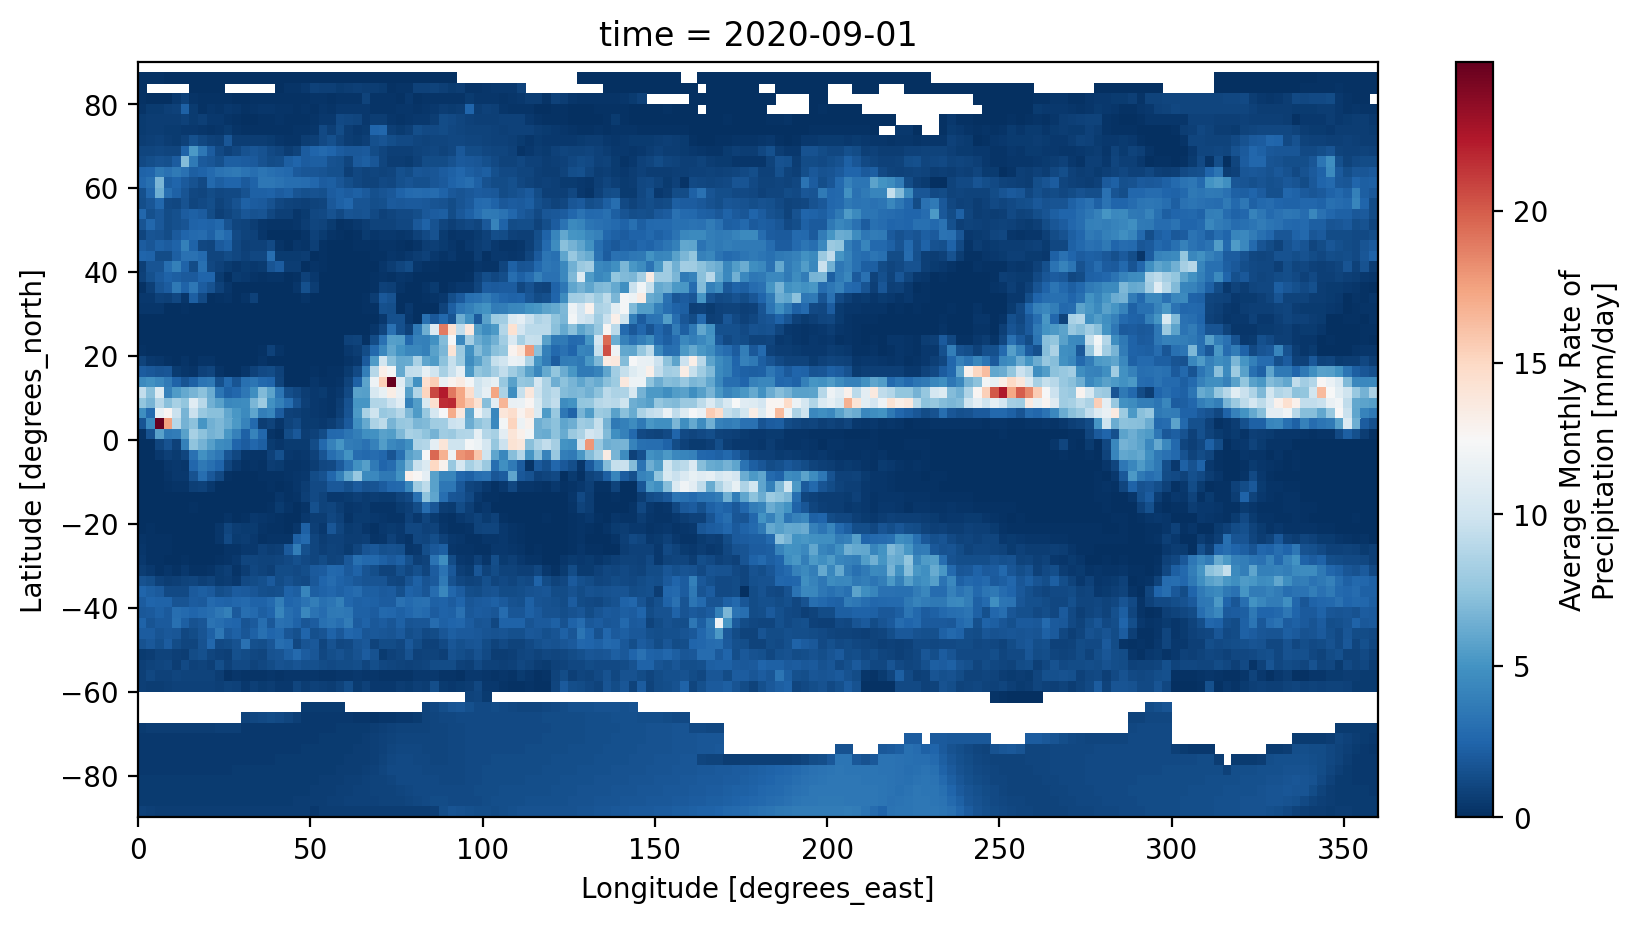

In [ ]:
precip.isel(time = 500).plot(cmap=plt.cm.RdBu_r)

This is a figure among all grids in September, 2020. From this figure, we can figure out average monthly rate of preciptation is higher near equator which makes sense (the blank place means missing values).

### Basemap

Basemap is a professional library for plotting 2D data on maps. Before drawing our first map, we should learn some knowledge about maps. To represent the curved surface of the earth on a two-dimensional map, we should use projections to accomplish. `lat_0` represents central latitude and `lon_0` represents central meridian. You can search these parameters on Google.

Ok, let's do our first map! We choose `orthographic projection`, `lon_0 = -105`, `lat_0 = 40`. Then, we use `basemap.fillcontinents` to fill color for continents, `basemap.drawparallels` and `basemap.drawmeridians` to draw longitude lines and latitude lines, `basemap.drawmapboundry` to fill color to map interior.

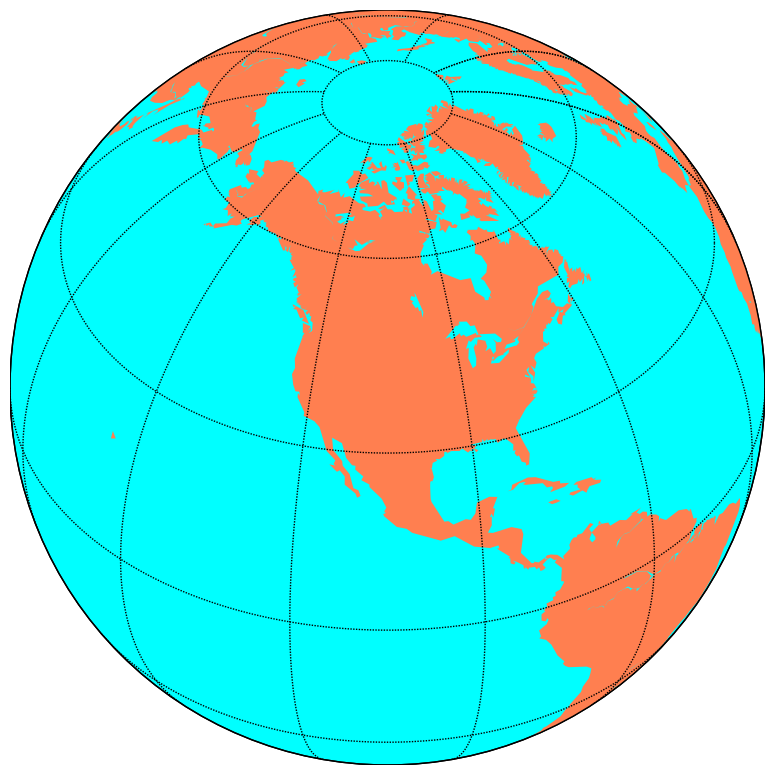

In [ ]:
# Setting up a map
bmap = Basemap(projection='ortho',lon_0=-105,lat_0=40)
fig = plt.figure(figsize = (10,10),dpi = 100)
ax=plt.gca() 
# fill color for continents
bmap.fillcontinents(color='coral',lake_color='aqua')
# draw longitude lines and latitude lines with sequece
bmap.drawparallels(np.arange(-90.,120.,30.))
bmap.drawmeridians(np.arange(0.,420.,30.))
# fill color to map interior
bmap.drawmapboundary(fill_color='aqua')

But sometimes, we only want a regional map. For example, we only want to see the United States on the map, we can first download the U.S. shapefile on https://www.census.gov/geographies/mapping-files/time-series/geo/carto-boundary-file.html (you can choose city, state or country,etc). Then using `basemap.readshapefile` to read shapefile.

In [ ]:
bmap = Basemap(projection='ortho',lon_0=-105,lat_0=40)
fig = plt.figure(figsize = (10,10),dpi = 100)
ax=plt.gca() 
bmap.fillcontinents(color='coral',lake_color='aqua')
bmap.drawparallels(np.arange(-90.,120.,30.))
bmap.drawmeridians(np.arange(0.,420.,30.))
bmap.drawmapboundary(fill_color='aqua')
# Read shapefile to draw states boundry for the U.S.
shp_info1=bmap.readshapefile('/content/15688-tutorial-data-main/cb_2018_us_state_500k/cb_2018_us_state_500k','states',color='black',linewidth=0.8)

Now, we can see the U.S. states boundry on the map, but we want to zoom in the U.S. region. So, we should set limit to the coordinates. In this case, we can only use x,y coordinates to limit region but not longtitude and latitude. Therefore, we use basemap to convert `lon`,`lat` to `x`,`y`.

(4497903.0843654685, 8417614.372131767)

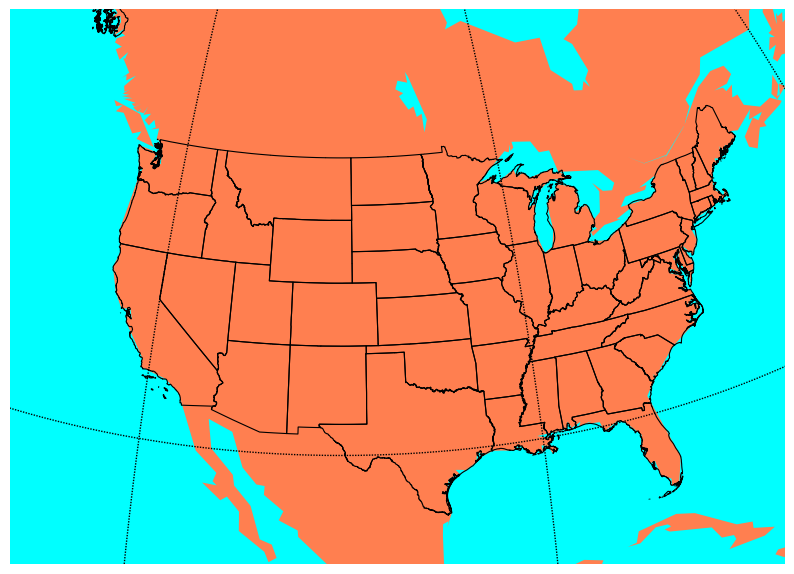

In [ ]:
# Google lat_0 and lon_0.
bmap = Basemap(projection='ortho',lon_0=-105,lat_0=40)
fig = plt.figure(figsize = (10,10),dpi = 100)
ax=plt.gca() 
bmap.fillcontinents(color='coral',lake_color='aqua')
bmap.drawparallels(np.arange(-90.,120.,30.))
bmap.drawmeridians(np.arange(0.,420.,30.))
bmap.drawmapboundary(fill_color='aqua')
shp_info1=bmap.readshapefile('/content/15688-tutorial-data-main/cb_2018_us_state_500k/cb_2018_us_state_500k','states',color='black',linewidth=0.8)
# I choose the map longtitude range from -128 to -55, and latitude range from 20, to 50
# transform longtitude and latitude by plugging these values into basemap, then we get x,y coordinates.
xmin, ymin = bmap(-128, 20)
xmax, ymax = bmap(-55, 50)
ax.set_xlim([xmin, xmax])
ax.set_ylim([ymin, ymax])

Now, we have a U.S. map with states boundry! However, We don't just want to draw a map but also want to plot data on the map. First, we should deal with those missing values. In this case, I choose to replace those missing values to 0 (you can also replace them with mean value or median value).

In [ ]:
precip500 = precip[500,:,:].values
precip500[np.isnan(precip500)] = 0
precip500 

array([[0.  , 0.  , 0.  , ..., 0.  , 0.  , 0.  ],
       [0.12, 0.12, 0.12, ..., 0.15, 0.15, 0.12],
       [0.1 , 0.  , 0.  , ..., 0.12, 0.1 , 0.12],
       ...,
       [0.51, 0.5 , 0.5 , ..., 0.5 , 0.49, 0.48],
       [0.53, 0.53, 0.52, ..., 0.55, 0.53, 0.52],
       [0.78, 0.71, 0.67, ..., 0.58, 0.57, 0.56]], dtype=float32)

In order to create grids on the map, we need to sort latitude and longitude values, and using `meshgrid` to become grids. Plotting data on the grids we can get a 2-D figure. However, lat and lon we have in the dataset are actually x,y value. We should convert x,y coordinates to lon,lat coordinates by using `basemap(x,y,inverse = True)`. Then using `contourf` or `pcolormesh` to plot it.

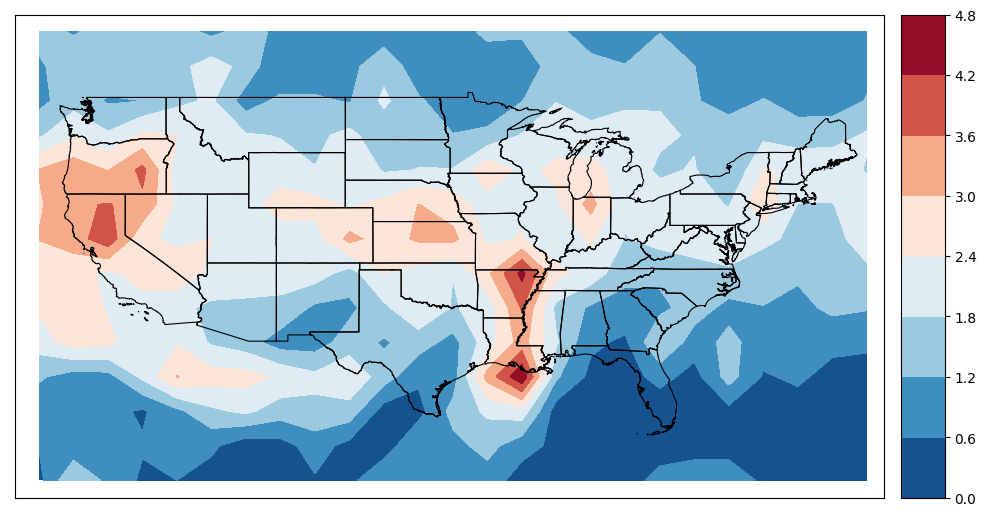

In [ ]:
# Setting up a map
bmap = Basemap(llcrnrlon=-128, llcrnrlat=20, urcrnrlon=-65.,urcrnrlat=55., lat_0 = 40., lon_0 = -80)
fig = plt.figure(figsize = (12,10),dpi = 100)
ax=plt.gca()
# Sort value to meshgrid
xx = sorted(data['lat'].values)
yy = sorted(data['lon'].values)
yy = [y-180 for y in yy]
xpt,ypt=np.meshgrid(xx,yy)
# Convert x,y coordinates to lon,lat coordinates
lonpt,latpt=bmap(xpt,ypt,inverse=True)
z0=precip500 
shp_info1=bmap.readshapefile('/content/15688-tutorial-data-main/cb_2018_us_state_500k/cb_2018_us_state_500k','states',color='black',linewidth=0.8)
cs=bmap.contourf(latpt,lonpt,z0.T,cmap=plt.cm.RdBu_r)
bmap.colorbar(cs, extend = 'min')

From this figure, we can see that western and southern of the U.S. have larger average monthly rate of precipitation.

## Animation

One application of this dataset is creating animation. Because one coordinate of our dataset is time, we can create gif to show the global or region precipitation change with time. First, we should save all the figures we want to use. For example, I saved data from 2021-02-1 to 2022-02-01. Then, we use `pillow` library to open these figure and make all of them as a gif.

In [ ]:
%%capture
# save figures
for i in range(505,518):
    fig = plt.figure()
    precip.isel(time = i).plot(cmap=plt.cm.RdBu_r)
    plt.savefig(f"/content/15688-tutorial-data-main/{i}",dpi = 200)

Using `Image` to open figures what we have saved and append all of them to a list. Then save them to a gif. [Note:] if you set `loop = 0`, that means keep looping your gif, if you set `loop = 1`, the gif will loop only one time.

In [ ]:
# create gif
from PIL import Image
images=[]
for i in range(505,518):
    # Open figures and append them to a list
    im=Image.open(f'/content/15688-tutorial-data-main/{i}.png'.format(i+1))
    images.append(im)
# Save as a gif
images[0].save("/content/15688-tutorial-data-main/precip_year.gif",save_all=True,loop=0,append_images=images[1:],duration=500)

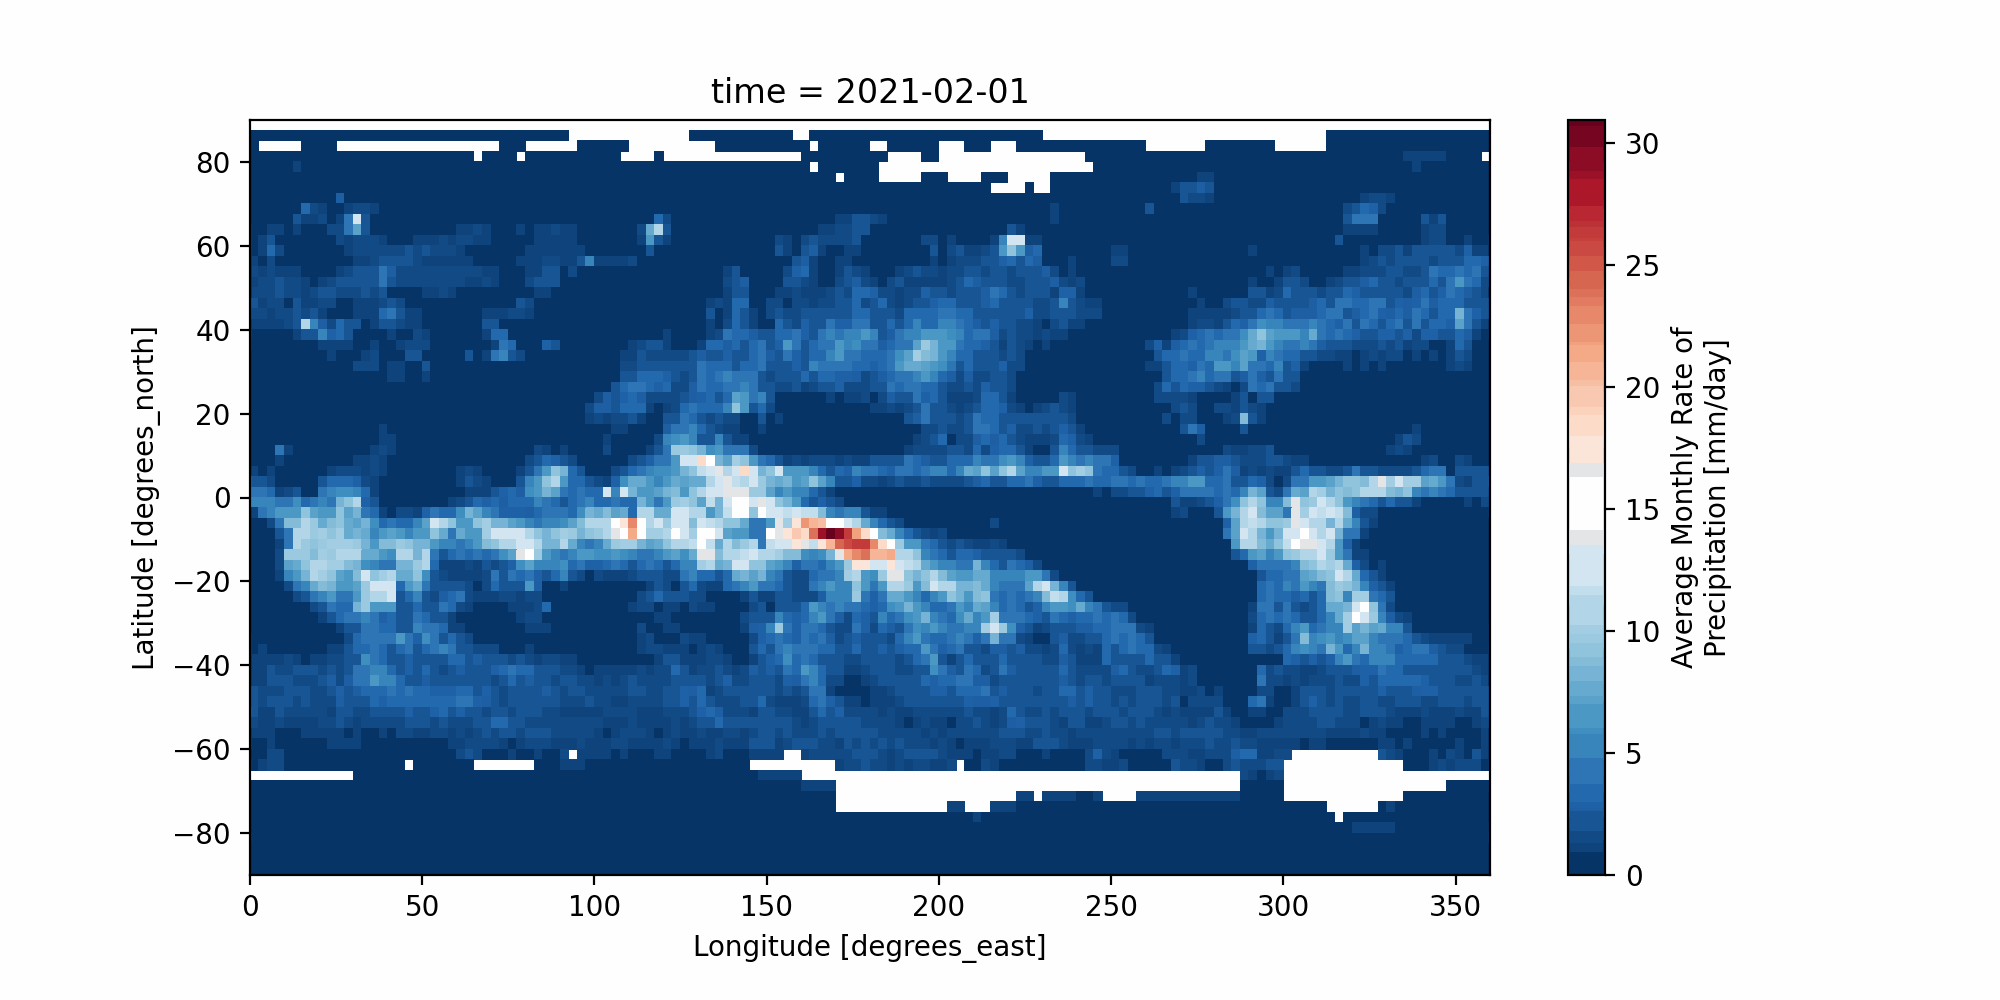

In [ ]:
# Show gif
from IPython.display import Image
Image(open("/content/15688-tutorial-data-main/precip_year.gif", 'rb').read())

This gif shows global average monthly rate of precipitation from 2021-02 to 2022-02. In general, preciprecipitation is greater at the equator than in other regions.

## Summary and references

dataset:https://psl.noaa.gov/data/gridded/data.cmap.html

netCDF4:https://unidata.github.io/netcdf4-python/

xarray:https://docs.xarray.dev/en/stable/

Basemap:https://matplotlib.org/basemap/

Convert coordinates:https://matplotlib.org/basemap/users/mapcoords.html

shapefile: https://www.census.gov/geographies/mapping-files/time-series/geo/carto-boundary-file.html